In [18]:
from imageio import imread
%matplotlib inline

## Approach

The main difficulty with the problem is the need to optimize the expected return and volatility at the same time for a large number of covariate variables. 

With no prior knowledge about the companies (e.g. their sectors), a good approach should involve optimizing a combined multivariate ARMA+GARCH autoregression model and proper estimation of the covariance matrix of returns. This typically implies construction of a multivariate likelihood for GARCH/ARMA which is used to obtain the covariance matrix using some simplifying assumptions about the intercorrelation of variables. 

A simpler approach is to partition the stocks using prior knowledge in combination with PCA. E.g. one can assume a certain number of groups (factors) and then use PCA to identify combinations of variables (principal components) that maximize the variance contained in the largest eigenvalues whose number is fixed by the number of factors. Then we can use the corresponding projection operator to translate returns into factor loadings, make an assumption about independence of the factors use a univariate autoregression model to to fit the data. I have chosen this approach for simplicity and not necessarily worse performance. Below I describe the steps of this algorithm. 

## Algorithm

### Preprocessing

*Adjust by splits and dividends* <br>
Divide historical prices at time t by the accumulated (back in time) split factors $S_t=s_T s_{T-1} ... s_{t+1}$<br>
Subtract total dividends $D_t=d_T+d_{T-1}+...+d_{t+1}$ from historical prices at time t.

*Log-returns*<br>
Switch to log-returns $r_n(t)=\log[{\rm price_n}(t)/{\rm price_n}(t-dt)]$, where $n$ is the stock number and $dt$ can be a hyperparameter of the model.

*Outlier detection*<br>
After taking the logarithm, returns should become closer to normal. It helps to set "dt" to a small number to push them further. This alleviates the task of detecting outliers that shoot up and come back over 2 time steps. If returns can be fitted by a Gaussian or t-distribution, one can estimate cumulative distributions and compare the observed 
quantiles that contain suspected outliers (say $\gtrsim5 \sigma$) with theoretical quantiles of 
the normal (or t-) distribution. Then if there is a large difference, after visual inspection these points 
could be discarded.

*Handle missing values*
1. *Isolated missing values*<br>
- If there is a single or few isolated missing values (e.g. holidays), one can use linear interpolation or even substitution by neighboring (previous) values.
2. *Extended missing regions*<br>
- For extended missing regions, linear interpolation induces bias toward lower frequencies.<br> 
- If values are assumed to be missing completely at random (MCAR) meaning that the probability to encounter 
a gap is independent of both the missing data and observed (in other variables/covariates) data distributions, 
the problem is reduced to maximizing likekihood on observed data, i.e. ignoring missing data completely, while 
still inferring parameters. Nothing else can be done in this case, and when a significant fraction of a time series 
is missing, it is reasonable to remove this variable completely.
- If values are assumed to be missing at random (MAR), i.e. if gaps depend on the distribution of 
observed data, but not the missing data, one can use the expectation maximization technique to generate missing values 
by maximizing the full data likelihood with respect to the conditional distribution of missing covariate. In other words, one utilizes mutual information between covariates to deal with gaps. However, because we are dealing with correlated and potentially heteroscedastic time series, a multivariate likelihood function for ARMA+ARCH has to be constructed and maximized to generate missing values. 

### Split data into training, validation and test sets 
Keep ~40% of the last history to split equally into the validation  and test sets. We will use the rest for training. Alternatively, to cross-validate, we can split the data into a few consecutive folds, use each of them for training and validation/testing in the same proportion and average the model score over the folds. On the validation set, we optimize our hyperparameters, and finaly evaluate the model on the test set. We always fit on the tain set, and then transform both the train and validation/test set according to the fitted parameters.

### Beta-neutrality: identify global trend

The market imposes a systematic trend on the evolution of stock prices. Let us apply a simplified version of CAPM  to decompose returns into the linear market contribution and the average active return $\alpha_{0n}$ for each stock n:

$r_n = \alpha_{0n} + \beta_n\ r_{Bn}$,

where $r_{nB}$ are the expected market returns and $\beta_n$ is a linear correlation coefficient between the total returns and the market returns. Assume the market has little effect on volatility.<br>

We can extract the long-term market contribution from our data e.g. by applying PCA to project the stock prices onto the pricipal component that contains the largest variance:

$r_{Bn} = r_{nm} e_m $, <br>

where $r_{nm}$ is the $N\times T$ matrix of stock returns and $e_m$ is the eigenvector of $r^T r$ in the direction of maximum variance. In certain cases, it can be worth looking at further few components, e.g. when there are seasonal or other periodic long-term variations in the data. Now we can easily determine $\alpha_{0n}$ and $\beta_n$ by linear regression (on the train set).

Note that because M=4000>N=2000>>1, the matrix $r^T r$ can be singular or ill-conditioned leading to high variance / numerical instability. For this reason, it makes sense to use regularized linear regression, such as Lasso or Ridge. Also note that although heteroskedasticity of returns will not bias the OLS estimator, it will damage the error statistics of the parameters. 

### Factorize stocks 

We are trying to find an optimal subspace of much lower dimensionality K$<<$N where the variance comprises a dominant fraction of the total variance, probably >95%. 

We can analyze how covariance matrices $\Sigma$ of log-returns change over time on the training set. First, we should introduce e.g. exponential smoothing on a scale of ~20-50 days (or shrinkage) to ensure the resulting covariance matrices are not dominated by noise. The smoothing scale can be optimized iteratively. Optionally, before PCA, stocks can be normalized by standard deviation: this way stocks with lower price but smalller volatility are not disfavored by PCA. 

We calculate covariance matrices in a sliding window of size close to the smoothing scale.

In general, the covariance matrix estimation will be biased in the presence of time correlations. So a heteroskedasticity and autocorrelation-robust estimator is preferred (like Newey–West). 

We can set the number of principal components (factors) based on some preliminary knowledge and then find an optimal PCA projection by averaging over time snapshots where the required amount of variance has been reached in the given number of components. If often such condition is not satisfied, we increase the scale of exponential smoothing. We use this single set of factors in all of the remaining calculations. In order to fit univariate ARMA/ARCH models to each factor, we further assume that our factors are independent at all times. This however is not required for portfolio optimization, where can use a full PCA projection of the covariance matrix onto the factor space instead of only its diagonal values. 

The factorized covariance matrix of shape (K,K) at a given time (not completely diagonal) after applying the PCA projection operator F of shape (N,K)
[its columns are K first eigenvectors of the covariance matrix]:

$\tilde{\Sigma} = F^T \Sigma F$

Log-returns $r_n$ and market $\beta_n$ are transformed by factorization as follows<br>
$r_n \rightarrow r_n' = F^T\ r_n$,<br>
$\beta_n \rightarrow \beta_n' = F^T\ \beta_n$

Experimenting with 4 years of data from NYSE, NASDAQ, and NYSE MKT (~1000 stocks, ~1000 days), exponential smoothing over 50 days with PCA allows to reduce the number of variables to 10 while keeping 95% of the variance (see below, features are hierarchically clustered by ClusterMap).

(<matplotlib.image.AxesImage at 0x7fe4ca0c7130>,
 (-0.5, 567.5, 571.5, -0.5),
 Text(0.5, 1.0, '~10 features after PCA'))

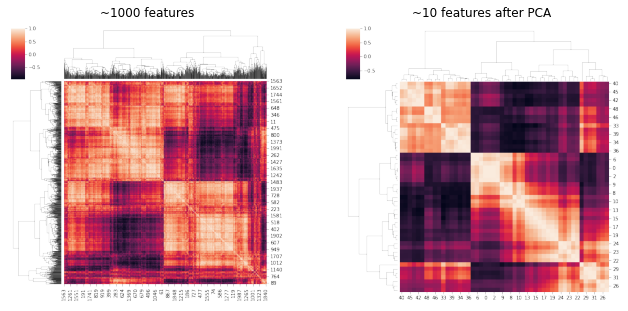

In [26]:
figure,axes = plt.subplots(1,2, figsize=(11,6))
axes[0].imshow(imread('cov1.png')), axes[0].axis('off'), axes[0].set_title('~1000 features')
axes[1].imshow(imread('cov2.png')), axes[1].axis('off'), axes[1].set_title('~10 features after PCA')

### Predicting time series

#### Smoothing before autoregression

In order to reduce noise in log-returns at the input to the autoregression model, we need to apply some smoothing:<br> 
$r_t' = \nu r_t' + (1-\nu) r_t'$ with smoothing parameter $\nu$.<br>

Parameter $\nu$ is inverse to the effective smoothing length. We use it as a hyperparameter to balance bias/variance of the model predictions on the validation set. Smoothing is less critical when we use factors though, because we have already filtered out some high-frequency noise by the PCA projection onto a subspace of much lower dimensionality. 

#### ARMA+GARCH

Apply univariate autoregression for each factor, for this reason factors are assumed independent.

1. *Model choice*
- First let us assume that the time series we want to predict are stationary and ergodic. This becomes a reasonable assumption if we fit our autoregression models to the market-adjusted returns, which is $\alpha_k'=r_k'-\beta'_k r_{Bk}'$ 
because they do not have a trend.
- Then we want to choose a suitable autoregression model, and ARMA is a natural choice. 
Whether we need to account for temporal correlations in the variance of $\alpha'(t)$ can be decided by seeing the residual errors after we had fitted $r_k'(t)$ by the CAPM model: $\epsilon_k(t) = r_k'(t)-\beta_k'(t) r_{Bk}'-\alpha_k'(t)$. We can as well look at autocorrelation functions calculated on returns and reason which ARMA/AR/MA could reproduce the observed tails 
based on their length and decay. Same can be done for variance to assess its autocorrelation. 
Using log-returns should suppress price variations around the mean to some extent, however there is still significant evolution of variance in the NYSE/NASDAQ data. Because we will need to minimize risk, it is safer to assume variance is correlated, so we need to adopt a GARCH model in addition to ARMA.

2. *Model formulation*
- ARMA(p,q): expectation<br>
    $\alpha_k'(t) = a_0 + \sum_{i=1}^p a_i \alpha_k'(t-i) + \sum_{i=0}^q b_i \zeta(t-i)$<br>
    
    
- GARCH(p,q): volatility<br>
    $\sigma^{2}_k(t) = c_0 + \sum_{i=1}^p c_i \epsilon_k(t-i) + \sum_{i=1}^q d_i \sigma^{2}_{k}(t-i)$<br>
   $\epsilon(t) = \xi(t) \sigma^2(t)$,<br>
 where $\sigma^{2}_k(t)$ is the variance of log-returns, $\zeta$ and $\xi$ are N(0,1) white noise. 
 
3. *Optimization*
- Obtain model parameters by minimizing the likelihood for the joint ARMA+GARCH model on the train set. Seek a model with the minimum number of parameters that results in a good bias/variance tradeoff on the validation set (data splits discussed above). Analyze the statistics of residuals to ensure there is no significant correlation. Vary the exponential smoothing length to see if it improves the model.


### Portfolio optimization problem

Now we have all the ingredients to build a portfolio optimizer on top of the prediction model.

#### Covariance matrix estimation

As mentioned earlier, we need to use an autocerrelation / heteroskedasticity robust estimator (e.g. Newey-West). 

#### Shrinkage of inputs to portfolio optimizer

Similar to smoothing, shrinkage can be applied to returns and covariance matrix at the input to the optimizer in order to reduce variance by providing regularization. It is introduced as a convex combination of the sample estimator $x_{\rm sm}$ (i.e. our estimated returns and covariance matrix, which are estimators with little structure, they fluctuate from time to time) and a shrinkage target $x_{\rm tg}$, which is some number or, for covariance, a matrix of identical numbers that characterize the global mean values (e.g. all-time mean return and variance):

$x \rightarrow (1-\gamma) x_{\rm sm} + \gamma x_{\rm tg}$,<br>
where $\gamma$ is the shrinkage intensity.

The shrinkage intensity and target are chosen differently depending on the particular shrinkage estimator (e.g. Stein). Shrinkage simply moves our estimates toward the global mean, and thus provides a regularizing effect to reduce fluctuating errors during portfolio optimization. When the intensity is too large, on the other hand, shrinkage can lead to high bias.  

#### Optimization

We need to minimize **risk-adjusted returns** (the Sharpe ratio):

${\rm Sh}=w\ r'^T / (w^T \tilde{\Sigma} w)^{1/2}$,

where $w=[w_0, ..., w_K]$ is the vector of weights of factorized stocks in the portfolio to be optimized,<br>
$w\ r'^T=E[r']=r_0' w_0 + ... + r_K' w_K$ is the expected return over the factors,<br>
$\tilde{\Sigma}$ is the factorized (K,K) covariance matrix of returns. $\tilde{\Sigma}$ can be non-diagonal if there is residual correlation between the factors, strict independence is not required for optimization.

**The constraints are:**
1. *Long-short strategy*<br>
    $\sum_k q_k^{-} \approx 1000$,<br>
    $\sum_k q_k^{+} \approx 1000$,<br>
    where $q_k^{-}$ and $q_k^{+}$ are the amounts of short and long assets in the $k$-factor. Then set<br>
    $\sum_k w_k^{-} / S_k = 1$,<br>
    $\sum_k w_k^{+} / S_k = 1$,<br>
    where $w_k^{-}$, $w_k^{+}$ are the absolute values of negative / positive stock weights and $S_k$ are split factors.


2. *Beta-neutrality*<br>
    $\sum_k \beta_k' w_k = 0$
    
Such optimization problem can be rendered convex by an appropriate mathematical transformation, so we can feed it to a numerical solver (such as cvxpy).


**This concludes the description of the algorithm:**
1. Preprocessing
2. Factorization
3. Univariate ARMA+GARCH for prediction in each factor
4. Optimize portfolio weights on predicted returns